# Log prob function

In [1]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\danie\miniconda3\envs\tf\lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
class GPTContainer:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # change to gpt-xl when running for real
        self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device) # change to gpt-xl when running for real
        
        self.starts = []
        self.suffs = []

        # Populate starts and suffs
        for i in range(len(self.tokenizer.get_vocab())):
            tok = self.tokenizer.decode(i)
            if tok[0] == " " or tok[0] == ".":
                self.starts.append(i)
            elif tok[0] != " ":
                self.suffs.append(i)
                    
    def gpt2_sent_prob(self, sent):
        logsoftmax = torch.nn.LogSoftmax(dim=-1)
        
        tokenizer = self.tokenizer
        model = self.model

        starts = self.starts
        suffs = self.suffs

        sent = ". " + sent + "."

        tokens = tokenizer.encode(sent)
        inputs = torch.tensor(tokens).to(self.device)

        with torch.no_grad():
            out = model(inputs)

        unsoft = out[0]
        lab1 = inputs.cpu().data.numpy()
        
        probs = []
        for x in range(len(lab1) - 1):

            lab = lab1[x + 1]
            unsoft1 = unsoft[x]

            if lab in starts:

                soft = logsoftmax(unsoft1[starts])
                prob = float(soft[starts.index(lab)].cpu().data.numpy())

            elif lab in suffs:

                soft = logsoftmax(unsoft1[suffs])
                prob = float(soft[suffs.index(lab)].cpu().data.numpy())

            probs.append(prob)

        prob = np.sum(probs)

        return prob


# Example usage

In [3]:
gpt = GPTContainer()

In [4]:
sentence = "A message has been sent to your account"
log_probability = gpt.gpt2_sent_prob(sentence)

# Creating log probabilities

In [5]:
dfsentence = pd.read_csv("our_df.csv", usecols=['sentence_pair', 'sentence1','sentence2','trial_type','subject','cluster','subjects_majority_vote_2clusters', 'subjects_majority_vote',  'subject_selected_sentence' ,'gpt_choice', 'include_as_gpt_item','gpt_engaged_subjects_agreement', 'subject_chose_majority_2clusters','agreement_2clusters'])
dfsentence = dfsentence[(dfsentence['include_as_gpt_item'] == True) & (dfsentence['cluster'].isin(['engaged_accurate', 'engaged_struggling']))]
dfsentence.reset_index(drop=True, inplace=True)

In [6]:
# # dfsentence = df.drop_duplicates(subset='sentence_pair')
# dfsentence[['sentence1', 'sentence2']] = dfsentence['sentence_pair'].str.split('_', expand=True)

In [7]:
# Calculate probabilities for each pair of sentences
probabilities = []
for index, row in dfsentence.iterrows():

    prob1 = gpt.gpt2_sent_prob(row['sentence1'])
    prob2 = gpt.gpt2_sent_prob(row['sentence2'])
    probabilities.append([prob1, prob2])

# Add probabilities to the DataFrame
dfsentence['probability_sentence1'] = [p[0] for p in probabilities]
dfsentence['probability_sentence2'] = [p[1] for p in probabilities]

In [8]:
# Push df to csv
dfsentence.to_csv('our_sentences_probs.csv', index=False)

# Revisioned version

In [9]:
class GPTContainer:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2") # change to gpt-xl when running for real
        self.model = GPT2LMHeadModel.from_pretrained("gpt2").to(self.device) # change to gpt-xl when running for real

                    
    def gpt2_sent_prob(self, sent):
        logsoftmax = torch.nn.LogSoftmax(dim=-1)
        
        tokenizer = self.tokenizer
        model = self.model

        sent = ". " + sent + "."

        tokens = tokenizer.encode(sent)
        inputs = torch.tensor(tokens).to(self.device)

        with torch.no_grad():
            out = model(inputs)

        unsoft = out[0]
        lab1 = inputs.cpu().data.numpy()
        
        probs = []
        for x in range(1, len(lab1) - 1):

            lab = lab1[x + 1]
            unsoft1 = unsoft[x]

            soft = logsoftmax(unsoft1)
            prob = float(soft[lab].cpu().data.numpy())
            probs.append(prob)

        prob = np.sum(probs)

        return prob

In [10]:
gpt = GPTContainer()

In [11]:
sentence = "A message has been sent to your account"
gpt.gpt2_sent_prob(sentence)

-22.974640369415283

In [12]:
# Calculate probabilities for each pair of sentences
probabilities = []
for index, row in dfsentence.iterrows():
    prob1 = gpt.gpt2_sent_prob(row['sentence1'])
    prob2 = gpt.gpt2_sent_prob(row['sentence2'])
    probabilities.append([prob1, prob2])

# Add probabilities to the DataFrame
dfsentence['probability_sentence1'] = [p[0] for p in probabilities]
dfsentence['probability_sentence2'] = [p[1] for p in probabilities]

In [13]:
# Push df to csv
dfsentence.to_csv('our_sentences_probs_revised.csv', index=False)

# Calculating differences between models

In [14]:
dforiginal = pd.read_csv('our_sentences_probs.csv')
dfrevised = pd.read_csv('our_sentences_probs_revised.csv')
df = pd.read_csv('our_df.csv')

In [15]:
dforiginal['selection'] = None
dfrevised['selection'] = None

# Iterate over each row in dforiginal
for index, row in dforiginal.iterrows():
    prob1_orig = row['probability_sentence1']
    prob2_orig = row['probability_sentence2']
    
    # Get the corresponding row from dfrevised
    row_revised = dfrevised.iloc[index]
    prob1_revised = row_revised['probability_sentence1']
    prob2_revised = row_revised['probability_sentence2']
    
    # Calculate the absolute differences for the original DataFrame
    diff1_orig = abs(0 - prob1_orig)
    diff2_orig = abs(0 - prob2_orig)
    
    # Calculate the absolute differences for the revised DataFrame
    diff1_revised = abs(0 - prob1_revised)
    diff2_revised = abs(0 - prob2_revised)
    
    # Compare the differences for both DataFrames
    if diff1_orig < diff2_orig:
        dforiginal.at[index, 'selection'] = 1
    else:
        dforiginal.at[index, 'selection'] = 2
    
    if diff1_revised < diff2_revised:
        dfrevised.at[index, 'selection'] = 1
    else:
        dfrevised.at[index, 'selection'] = 2

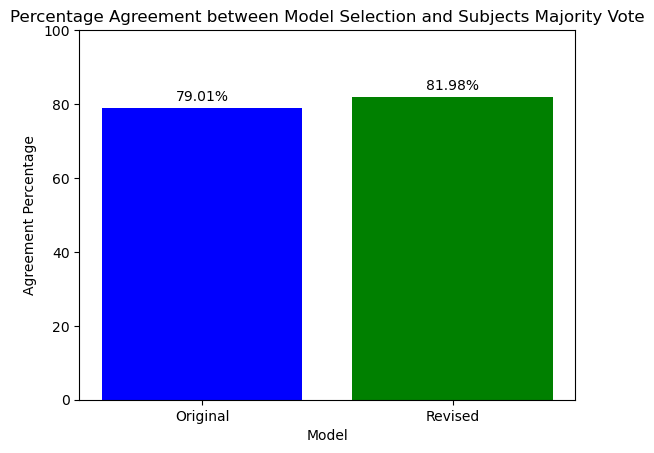

In [16]:
# Compute agreement percentage for original DataFrame
original_agreement = (dforiginal.groupby('sentence_pair')['selection'].unique() == dforiginal.\
                      groupby('sentence_pair')['subjects_majority_vote_2clusters'].unique()).mean() * 100

# Compute agreement percentage for revised DataFrame
revised_agreement = (dfrevised.groupby('sentence_pair')['selection'].unique() == dfrevised.\
                     groupby('sentence_pair')['subjects_majority_vote_2clusters'].unique()).mean() * 100

# Plot the agreement percentages as a bar plot
plt.bar(['Original', 'Revised'], [original_agreement, revised_agreement], color=['blue', 'green'])
plt.title('Percentage Agreement between Model Selection and Subjects Majority Vote')
plt.xlabel('Model')
plt.ylabel('Agreement Percentage')
plt.ylim(0, 100)

for i, v in enumerate([original_agreement, revised_agreement]):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center', va='bottom')

# Show plot
plt.show()

In [34]:
#items_df = df[df['include_as_gpt_item'] == True].groupby('sentence_pair')[['trial_type', 'gpt_all_subjects_agreement']].first()
items_df_og= df[df['include_as_gpt_item'] == True].groupby('sentence_pair').agg({'trial_type': 'first', 'gpt_all_subjects_agreement': np.mean})

# Original results
avg_gpt_subject_agreement_og = items_df_og.groupby('trial_type')['gpt_all_subjects_agreement'].mean() * 100


# Original probabilities with clustering
dforiginal['originalproba_agreement'] = np.where(
    dforiginal['selection'] == dforiginal['subjects_majority_vote_2clusters'], 
    1, 
    0
)

items_df_original_clust = dforiginal.groupby('sentence_pair').agg({'trial_type': 'first', 'originalproba_agreement': np.mean})
avg_gpt_subject_agreement_og_clust = items_df_original_clust.groupby('trial_type')['originalproba_agreement'].mean() * 100


# Revised probability with clustering
dfrevised['engagedgpt_revisedproba_agreement'] = np.where(
    dfrevised['selection'] == dfrevised['subjects_majority_vote_2clusters'], 
    1, 
    0
)

items_df_revised_clust = dfrevised.groupby('sentence_pair').agg({'trial_type': 'first', 'engagedgpt_revisedproba_agreement': np.mean})
avg_gpt_subject_agreement_clust = items_df_revised_clust.groupby('trial_type')['engagedgpt_revisedproba_agreement'].mean() * 100


# Without the clustering
dfrevised['revisedproba_agreement'] = np.where(
    dfrevised['selection'] == dfrevised['subjects_majority_vote'], 
    1, 
    0
)

items_df_revised = dfrevised.groupby('sentence_pair').agg({'trial_type': 'first', 'revisedproba_agreement': np.mean})
avg_gpt_subject_agreement = items_df_revised.groupby('trial_type')['revisedproba_agreement'].mean() * 100

C:\Users\danie\AppData\Local\Temp\ipykernel_4408\1538839913.py:2: FutureWarning: The provided callable <function mean at 0x000001CFDEB25480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  items_df_og= df[df['include_as_gpt_item'] == True].groupby('sentence_pair').agg({'trial_type': 'first', 'gpt_all_subjects_agreement': np.mean})
C:\Users\danie\AppData\Local\Temp\ipykernel_4408\1538839913.py:15: FutureWarning: The provided callable <function mean at 0x000001CFDEB25480> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  items_df_original_clust = dforiginal.groupby('sentence_pair').agg({'trial_type': 'first', 'originalproba_agreement': np.mean})
C:\Users\danie\AppData\Local\Temp\ipykernel_4408\1538839913.py:26: FutureWarning: The provided cal

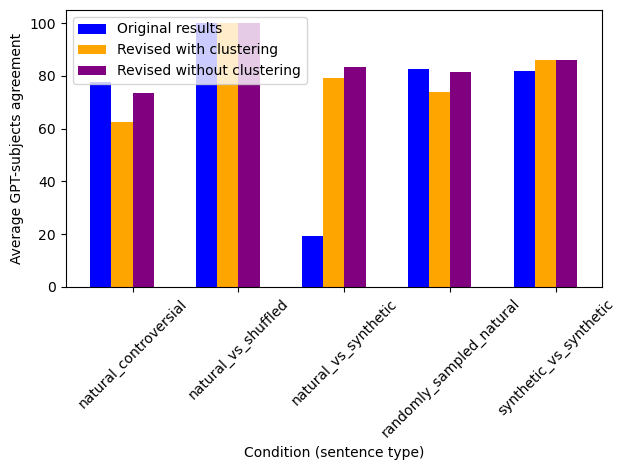

In [31]:
# Define the width of each bar
bar_width = 0.2

# Generate the x-coordinates for the bars
x_values_og = np.arange(len(avg_gpt_subject_agreement_og))
x_values_clust = np.arange(len(avg_gpt_subject_agreement_clust))
x_values_revised = np.arange(len(avg_gpt_subject_agreement))

# Plot original results (avg_gpt_subject_agreement_og) in blue
plt.bar(x_values_og - bar_width*1.5, avg_gpt_subject_agreement_og.values, bar_width, color='blue', label='Original results')

# Plot revised results with clustering (avg_gpt_subject_agreement_clust) in orange
plt.bar(x_values_clust - bar_width/2, avg_gpt_subject_agreement_clust.values, bar_width, color='orange', label='Revised with clustering')

# Plot revised results without clustering (avg_gpt_subject_agreement) in purple
plt.bar(x_values_revised + bar_width/2, avg_gpt_subject_agreement.values, bar_width, color='purple', label='Revised without clustering')

plt.xlabel('Condition (sentence type)')
plt.ylabel('Average GPT-subjects agreement')
plt.xticks(x_values_og, avg_gpt_subject_agreement_og.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


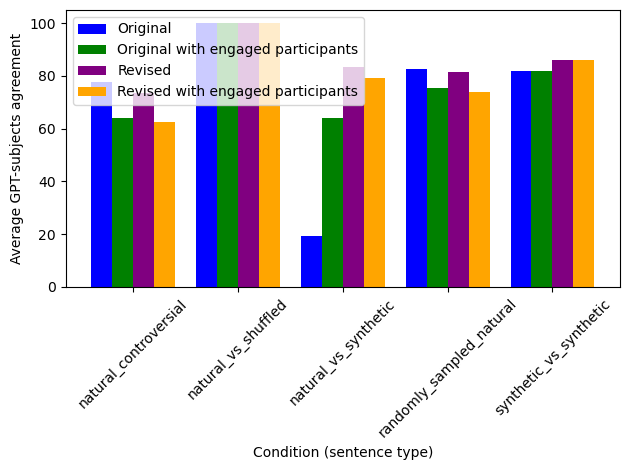

In [38]:
# Define the width of each bar
bar_width = 0.2

# Generate the x-coordinates for the bars
x_values_og = np.arange(len(avg_gpt_subject_agreement_og))
x_values_og_clust = np.arange(len(avg_gpt_subject_agreement_og_clust))
x_values_revised = np.arange(len(avg_gpt_subject_agreement))
x_values_revised_clust = np.arange(len(avg_gpt_subject_agreement_clust))

# Plot original results (avg_gpt_subject_agreement_og) in blue
plt.bar(x_values_og - bar_width*1.5, avg_gpt_subject_agreement_og.values, bar_width, color='blue', label='Original')

# Plot original results with clustering (avg_gpt_subject_agreement_og_clust) in green
plt.bar(x_values_og_clust - bar_width/2, avg_gpt_subject_agreement_og_clust.values, bar_width, color='green', label='Original with engaged participants')

# Plot revised results without clustering (avg_gpt_subject_agreement) in purple
plt.bar(x_values_revised + bar_width/2, avg_gpt_subject_agreement.values, bar_width, color='purple', label='Revised')

# Plot revised results with clustering (avg_gpt_subject_agreement_clust) in orange
plt.bar(x_values_revised_clust + bar_width*1.5, avg_gpt_subject_agreement_clust.values, bar_width, color='orange', label='Revised with engaged participants')

plt.xlabel('Condition (sentence type)')
plt.ylabel('Average GPT-subjects agreement')
plt.xticks(x_values_og, avg_gpt_subject_agreement_og.index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()